# Claude Haiku 3.5 baseline

This notebook outlines the steps undertook to generate a baseline prediction using Claude Haiku 3.5 from Bedrock.

I'm using the same prompt shared by Pau with slight modification based on the style of my exerpts.

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

from prediction_utils import predict
from evaluate_predictions import show_metrics

from instructions import baseline_instructions
MODEL_ID = "anthropic.claude-3-5-haiku-20241022-v1:0"
SYSTEM_PROMPT = baseline_instructions

# Load the data

In [2]:
df = pd.read_csv("data/dataset.csv")
df.head()

,filename,citing_opinion_id,citing_index,court,docket_id,cluster_id,citing_decision_name,cited_opinion_id,cited_index,depth,cited_decision_name,overruled,notes
0,0001.91306_cites_88061.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88061,0,3,Texas v. White (1869),yes,NaN
1,0002.91306_cites_88994.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88994,1,2,Vermilye & Co. v. Adams Express Co. (1875),no,NaN
2,0003.91306_cites_87633.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",87633,2,1,Murray v. Lardner (1865),no,NaN
3,0004.91306_cites_88240.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88240,3,1,Texas v. Hardenberg (1869),no,NaN
4,0005.91306_cites_88693.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88693,4,1,Huntington v. Texas (1873),no,NaN


# Use the model to generation predictions

In [3]:
%%time
predictions = predict(df, MODEL_ID, SYSTEM_PROMPT)
predictions[:2]

INFO:botocore.tokens:Loading cached SSO token for flp-sso
INFO:botocore.tokens:Loading cached SSO token for flp-sso
INFO:botocore.tokens:Loading cached SSO token for flp-sso
INFO:botocore.tokens:Loading cached SSO token for flp-sso
INFO:botocore.tokens:Loading cached SSO token for flp-sso
INFO:httpx:HTTP Request: POST https://bedrock-runtime.us-west-2.amazonaws.com/model/anthropic.claude-3-5-haiku-20241022-v1:0/invoke "HTTP/1.1 200 OK"
INFO:root:Completed: 4
INFO:httpx:HTTP Request: POST https://bedrock-runtime.us-west-2.amazonaws.com/model/anthropic.claude-3-5-haiku-20241022-v1:0/invoke "HTTP/1.1 200 OK"
INFO:root:Completed: 2
INFO:httpx:HTTP Request: POST https://bedrock-runtime.us-west-2.amazonaws.com/model/anthropic.claude-3-5-haiku-20241022-v1:0/invoke "HTTP/1.1 200 OK"
INFO:root:Completed: 3
INFO:httpx:HTTP Request: POST https://bedrock-runtime.us-west-2.amazonaws.com/model/anthropic.claude-3-5-haiku-20241022-v1:0/invoke "HTTP/1.1 200 OK"
INFO:root:Completed: 0
INFO:httpx:HTTP Re

CPU times: user 50.5 s, sys: 6.04 s, total: 56.6 s
Wall time: 24min 3s


[{'0005.91306_cites_88693.txt': {'model': 'claude-3-5-haiku-20241022',
   'input_tokens': 860,
   'output_tokens': 139,
   'prediction': 'no',
   'confidence': 0.8,
   'rationale': 'The passage does not overrule the <targetCase>16 Wall. 402</targetCase> case. Instead, the court is referencing and clarifying its previous decisions. The language suggests the court is providing additional context and nuance to its earlier rulings, specifically noting that they did not absolutely void the repealing act and that under certain circumstances (lawful purpose), the title could pass to the holder. This is an interpretation and refinement of previous holdings, not an overruling of the case itself.',
   'raw_results': '{\n"overruled": "no",\n"confidence": 0.8,\n"rationale": "The passage does not overrule the <targetCase>16 Wall. 402</targetCase> case. Instead, the court is referencing and clarifying its previous decisions. The language suggests the court is providing additional context and nuance 

In [7]:
prediction_df = pd.DataFrame([
    {"filename": filename, **details} 
    for prediction in predictions 
    for filename, details in prediction.items()
])
prediction_df.head()

,filename,model,input_tokens,output_tokens,prediction,confidence,rationale,raw_results
0,0005.91306_cites_88693.txt,claude-3-5-haiku-20241022,860,139,no,0.8,The passage does not overrule the <targetCase>...,"{\n""overruled"": ""no"",\n""confidence"": 0.8,\n""ra..."
1,0003.91306_cites_87633.txt,claude-3-5-haiku-20241022,889,179,no,0.7,The passage does not overrule the case <target...,"{\n""overruled"": ""no"",\n""confidence"": 0.7,\n""ra..."
2,0004.91306_cites_88240.txt,claude-3-5-haiku-20241022,855,170,no,0.7,The passage does not indicate that the case <t...,"{\n""overruled"": ""no"",\n""confidence"": 0.7,\n""ra..."
3,0001.91306_cites_88061.txt,claude-3-5-haiku-20241022,1691,216,yes,0.9,The passage explicitly states that the origina...,"{\n ""overruled"": ""yes"",\n ""confidence"": ..."
4,0002.91306_cites_88994.txt,claude-3-5-haiku-20241022,1372,203,no,0.7,The passage does not explicitly overrule the c...,"{\n""overruled"": ""no"",\n""confidence"": 0.7,\n""ra..."


## Save the raw prediction results

In [5]:
prediction_df.to_csv("predictions/1.claude/0.haiku3.5_baseline.csv", index=False)

## Check if any datapoints did not get prediction results and need to be re-predicted or cleaned

In [6]:
prediction_df["prediction"].isna().sum()

20

In [23]:
# Here I manually reviewed these cases in Google Sheets and replaced with the cleaned version
prediction_df = pd.read_csv("predictions/1.claude/0.haiku3.5_baseline.csv")

In [24]:
prediction_df["prediction"].isna().sum()

0

# Combine the prediction results with label for evaluation

In [25]:
assert len(df) == len(prediction_df)

In [26]:
eval_df = df.merge(prediction_df, how="left", on="filename")
eval_df.head()

,filename,citing_opinion_id,citing_index,court,docket_id,cluster_id,citing_decision_name,cited_opinion_id,cited_index,depth,cited_decision_name,overruled,notes,model,input_tokens,output_tokens,prediction,confidence,rationale,raw_results
0,0001.91306_cites_88061.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88061,0,3,Texas v. White (1869),yes,NaN,claude-3-5-haiku-20241022,1691,216,yes,0.9,The passage explicitly states that the origina...,"{\n ""overruled"": ""yes"",\n ""confidence"": ..."
1,0002.91306_cites_88994.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88994,1,2,Vermilye & Co. v. Adams Express Co. (1875),no,NaN,claude-3-5-haiku-20241022,1372,203,no,0.7,The passage does not explicitly overrule the c...,"{\n""overruled"": ""no"",\n""confidence"": 0.7,\n""ra..."
2,0003.91306_cites_87633.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",87633,2,1,Murray v. Lardner (1865),no,NaN,claude-3-5-haiku-20241022,889,179,no,0.7,The passage does not overrule the case <target...,"{\n""overruled"": ""no"",\n""confidence"": 0.7,\n""ra..."
3,0004.91306_cites_88240.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88240,3,1,Texas v. Hardenberg (1869),no,NaN,claude-3-5-haiku-20241022,855,170,no,0.7,The passage does not indicate that the case <t...,"{\n""overruled"": ""no"",\n""confidence"": 0.7,\n""ra..."
4,0005.91306_cites_88693.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88693,4,1,Huntington v. Texas (1873),no,NaN,claude-3-5-haiku-20241022,860,139,no,0.8,The passage does not overrule the <targetCase>...,"{\n""overruled"": ""no"",\n""confidence"": 0.8,\n""ra..."


# Run evaluation

In [27]:
df["overruled"].value_counts()

overruled
no     935
yes    149
Name: count, dtype: int64

In [28]:
eval_df["overruled"].value_counts()

overruled
no     935
yes    149
Name: count, dtype: int64

In [29]:
eval_df["prediction"].value_counts()

prediction
no           819
yes          259
partially      6
Name: count, dtype: int64

In [30]:
eval_df["input_tokens"].sum()

2268354

In [31]:
eval_df["output_tokens"].sum()

249544

In [32]:
y_true = eval_df["overruled"].map({"yes": 1, "no": 0})
y_pred = eval_df["prediction"].map({"yes": 1, "no": 0, "partially": 1})

In [33]:
report = classification_report(y_true, y_pred, target_names=["No", "Yes"])
print(report)

              precision    recall  f1-score   support

          No       0.96      0.84      0.89       935
         Yes       0.43      0.77      0.55       149

    accuracy                           0.83      1084
   macro avg       0.69      0.80      0.72      1084
weighted avg       0.88      0.83      0.85      1084



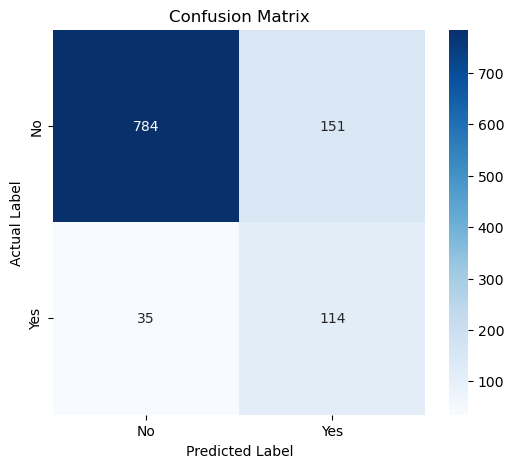

In [34]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

In [35]:
show_metrics(cm, y_true)

precision: of all predicted positives, how many were actual positives
recall: of all actual positives, how many we predicted to be positives
---------
METRICS
Accuracy: 0.83
Precision: 0.43
Recall: 0.77
F-score: 0.55
Specificity: 0.84
---------
DATASET
Total Responses: 1084
Total Positives: 149
Total Negatives: 935
---------
RECOUNT
True positives: 114
True negatives: 784
False positives: 151
False negatives: 35


In [36]:
confidently_wrong_positive = (eval_df["prediction"] == "yes") & (eval_df["overruled"] == "no") & (eval_df["confidence"] >= 0.8)
confidently_wrong_positive.sum()

146

In [37]:
confidently_wrong_negative = (eval_df["prediction"] == "no") & (eval_df["overruled"] == "yes") & (eval_df["confidence"] >= 0.8)
confidently_wrong_negative.sum()

15

# Save the evaluation df

In [38]:
eval_df.head()

,filename,citing_opinion_id,citing_index,court,docket_id,cluster_id,citing_decision_name,cited_opinion_id,cited_index,depth,cited_decision_name,overruled,notes,model,input_tokens,output_tokens,prediction,confidence,rationale,raw_results
0,0001.91306_cites_88061.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88061,0,3,Texas v. White (1869),yes,NaN,claude-3-5-haiku-20241022,1691,216,yes,0.9,The passage explicitly states that the origina...,"{\n ""overruled"": ""yes"",\n ""confidence"": ..."
1,0002.91306_cites_88994.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88994,1,2,Vermilye & Co. v. Adams Express Co. (1875),no,NaN,claude-3-5-haiku-20241022,1372,203,no,0.7,The passage does not explicitly overrule the c...,"{\n""overruled"": ""no"",\n""confidence"": 0.7,\n""ra..."
2,0003.91306_cites_87633.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",87633,2,1,Murray v. Lardner (1865),no,NaN,claude-3-5-haiku-20241022,889,179,no,0.7,The passage does not overrule the case <target...,"{\n""overruled"": ""no"",\n""confidence"": 0.7,\n""ra..."
3,0004.91306_cites_88240.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88240,3,1,Texas v. Hardenberg (1869),no,NaN,claude-3-5-haiku-20241022,855,170,no,0.7,The passage does not indicate that the case <t...,"{\n""overruled"": ""no"",\n""confidence"": 0.7,\n""ra..."
4,0005.91306_cites_88693.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88693,4,1,Huntington v. Texas (1873),no,NaN,claude-3-5-haiku-20241022,860,139,no,0.8,The passage does not overrule the <targetCase>...,"{\n""overruled"": ""no"",\n""confidence"": 0.8,\n""ra..."


In [39]:
eval_df.to_csv("predictions/1.claude/0.haiku3.5_baseline_eval.csv", index=False)